## d-block model: Accelerating spiking neural network training

Spiking neural networks (SNNs) are artificial neural networks that mimic the biophysics of the brain. There is a growing interest in using these networks to study the brain on computers and to use these networks to obtain energy efficient compute (when emulated on specialised neuromorphic hardware). Training SNNs remains challenging to date, as these networks are non-differentiable, due to the binary activation function (i.e. spike or no spike). A workaround - known as surrogate gradients - replaces the undefined derivates with suitable functions, and this seems to work well in practice. Problematic, however, is the slow training speed, as the network needs to be simulated for every discretised point in time. The d-block aims to remedy this problem, which we demonstrate in this tutorial.

## 1. Comparison between the d-block and standard spiking neural network model

Unlike the standard SNN where the neuron can spike at every simulation point, the d-block model is bound to spike at most d times, as the simulation duration is subdivided into d bins (and only a single spike can be emitted in a bin).

In [122]:
import torch
torch.manual_seed(42)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from block.nn import methods
from dblock.nn.layers import LinearNeurons, LinearDNeurons

In [124]:
n_in = 10  # Number of input neurons
n_out = 1  # Number of hidden neurons
t_len = 128  # Number of simulation time-steps

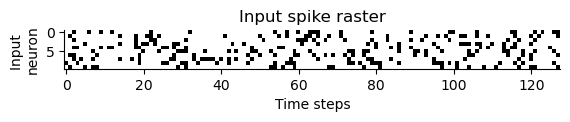

In [125]:
# Define some example spike input

def generate_spikes(b, n_in, t_len, thesh=0.8):
    torch.manual_seed(20)
    example_spikes = torch.rand(b, n_in, t_len)
    example_spikes[example_spikes > thesh] = 1
    example_spikes[example_spikes < 1] = 0
    
    return example_spikes

example_spikes = generate_spikes(1, n_in, t_len)
plt.imshow(example_spikes[0], cmap=plt.cm.gray_r)
plt.title("Input spike raster")
plt.xlabel("Time steps")
plt.ylabel("Input \nneuron")
sns.despine()

FS
single_spike False integrator False
recurrent_source None
FS
single_spike False integrator False
recurrent_source None


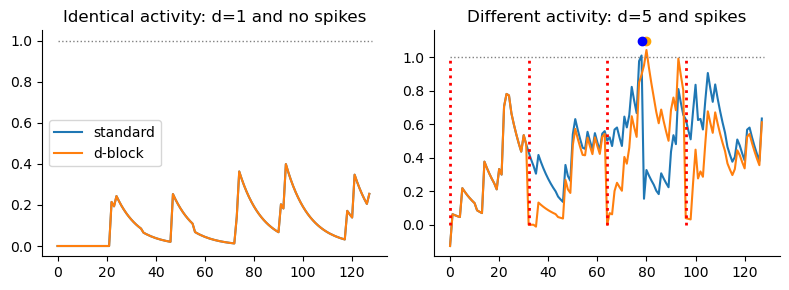

In [126]:
def plot_activity(ax, title, same=False):
    if same: 
        example_spikes = generate_spikes(1, n_in, t_len, thesh=0.99)
        dblock_model = LinearDNeurons(n_in=n_in, n_out=n_out, d=1, recurrent=False, method="fast_naive", t_len=t_len)
    else: 
        example_spikes = generate_spikes(1, n_in, t_len, thesh=0.95)
        dblock_model = LinearDNeurons(n_in=n_in, n_out=n_out, d=4, recurrent=False, method="fast_naive", t_len=t_len)
    
    standard_model = LinearNeurons(n_in=n_in, n_out=n_out, method="standard", t_len=t_len, single_spike=False)
    standard_model._to_current = dblock_model._to_input_current
    
    with torch.no_grad():
        standard_spikes, standard_mem = standard_model(example_spikes, return_type=methods.RETURN_SPIKES_AND_MEM)
        block_spikes, block_mem = dblock_model(example_spikes, return_type=methods.RETURN_SPIKES_AND_MEM)
        
    standard_mem = standard_mem.detach()[0, 0]
    block_mem = block_mem.detach()[0, 0]
    ax.plot(standard_mem)
    ax.plot(block_mem)
    ax.plot([0, t_len], [1, 1], ":", c="gray", linewidth=1)
    ax.set_title(title)
    
    block_spikes = [i for i, s in enumerate(block_spikes[0, 0]) if s]
    plt.scatter(block_spikes, 1.1*np.ones(len(block_spikes)), c="orange")
    standard_spikes = [i for i, s in enumerate(standard_spikes[0, 0]) if s]
    plt.scatter(standard_spikes, 1.1*np.ones(len(standard_spikes)), c="b")
    
    # Plot block separation lines
    if not same:
        dt = int(t_len / 4)
        for i in range(4):
            ax.plot([i*dt, i*dt], [0, 1], ":", c="red", linewidth=2)
    
    # Plot legend
    if same:
        ax.legend(["standard", "d-block"])
    
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plot_activity(axs[0], "Identical activity: d=1 and no spikes", same=True)
plot_activity(axs[1], "Different activity: d=5 and spikes", same=False)
sns.despine()
fig.tight_layout()

We see when d=1 and no spikes are emitted (left subplot), the membrane potentials are identical between the standard SNN and d-block model. However, as soon as d>1, the membrane potentials start to look slightly different between the models (right plot) for two reasons: 1. Membrane potential values "reset" as soon as the end of a block length is reached (orange line drops when the end of the block duration is reached - which is the dotted red line) and 2. Unlike in the standard model, the membrane potential is not reset in the d-block model when a spike is emitted. However, even with these changes, the dynamics of the d-block and standard SNN play out similarly (e.g. the similar spike times denoted by the big blue and orange dot).

## 2. Faster training speeds with d-block

Formally the d-block model differs from the standard SNN in that the refractory period is stochastic (i.e. the neuron needs to wait until the end of a block duration to spike again) as well as the recurrent conductance latencies (i.e. spikes in one block are recurrently connected to the next block). These assumptions - with proper implementation - allow the d-block model to be trained a lot faster than the standard SNN (where the speedup comes from avoiding lots of slow sequential operations and using faster convolutional ones - see paper for theory). To demonstrate the training speed advantages, we benchmark the training duration of a single backprop pass in the d-block and standard SNN model.

In [127]:
import time
import pandas as pd
torch.backends.cudnn.benchmark = True  # Make sure we use the best conv algorithm

In [101]:
n_in = 200  # Number of input neurons
n_out = 100  # Number of hidden neurons
t_len = 1024  # Number of simulation time-steps

In [102]:
sample_training_batch = generate_spikes(128, n_in, t_len)
standard_model = LinearNeurons(n_in=n_in, n_out=n_out, method="standard", t_len=t_len, single_spike=False)
dblock_model = LinearDNeurons(n_in=n_in, n_out=n_out, d=4, recurrent=False, method="fast_naive", t_len=t_len)

single_spike False integrator False
recurrent_source None
FS


In [104]:
def get_training_duration(model, device="cpu"):
    model = model.to(device)
    data = sample_training_batch.to(device)
    torch.cuda.synchronize()
    start_time = time.time()
    output = model(data)
    loss = output.sum()  # Arbitraty loss just so we have something to backpropogate
    loss.backward()
    torch.cuda.synchronize()
    training_duration = time.time() - start_time
    return training_duration

In [106]:
def get_training_durations_for_both_models(device):
    standard_training_times = [get_training_duration(standard_model, device) for _ in range(31)][1:]
    dblock_training_times = [get_training_duration(dblock_model, device) for _ in range(31)][1:]
    return pd.DataFrame({"standard": standard_training_times, "dblock": dblock_training_times})

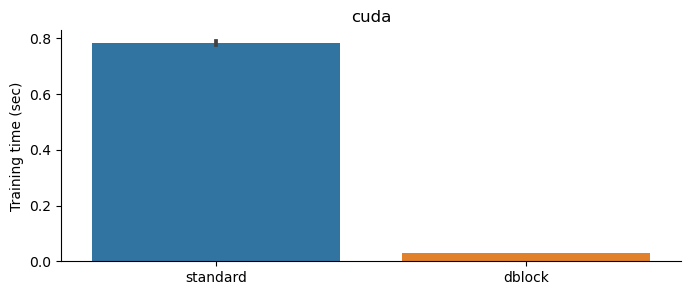

In [109]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3))

def plot_training_durations(ax, device):
    sns.barplot(get_training_durations_for_both_models(device), ax=ax)
    ax.set(ylabel="Training time (sec)", title=device)
    sns.despine()

plot_training_durations(axs, "cuda")

The d-block trains a great deal faster!

## 3. Training the d-block model on the SHD dataset

Not only does the d-block model train faster than the standard SNN, it is also able to obtain impressive performance on challenging neuromorphic datasets, such as the SHD dataset.

In [118]:
import os
import logging
from pathlib import Path

import numpy as np
from brainbox.trainer import compute_metric

from dblock.models import SHDDModel
from dblock.datasets import SHDDataset
from dblock.datasets.transforms import List
from dblock.trainer import Trainer

logging.disable("INFO")

# Lets setup those dataset splits
shd_path = os.path.join(Path(os.path.abspath("")).parent, "data/SHD")
train_dataset = SHDDataset(shd_path, train=True, transform=List.get_shd_transform(500))
test_dataset = SHDDataset(shd_path, train=False, transform=List.get_shd_transform(500))

# Little function to calculate accuracies
def get_test_accuracy(model, dataset):
    
    def count_correct(output, target):
        _, predictions = torch.max(output, 1)
        return (predictions == target).sum().cpu().item()
    
    n_correct = compute_metric(model, dataset, count_correct)
    return np.array(n_correct).sum() / len(dataset)

In [119]:
# Lets instantiate our model and trainer
n_epochs = 30
batch_size = 128
lr = 0.0004
model = SHDDModel(30, True, "fast_naive", t_len=500, n_neurons=400, n_layers=2, detach_recurrent_spikes=True, heterogeneous_beta=True, beta_requires_grad=True, readout_max=False)
trainer = Trainer(None, model, train_dataset, n_epochs, batch_size, lr, [-1])
trainer.train(save=False)

d=30 recurrent=True method=fast_naive t_len=500 n_neurons=400 n_layers=2 detach_recurrent_spikes=True heterogeneous_beta=True
beta_requires_grad=True readout_max=False single_spike=True
kwargs={}
building d2 layer.. {'single_spike': True, 'scale': 10, 'detach_recurrent_spikes': True}
FS
building d2 layer.. {'single_spike': True, 'scale': 10, 'detach_recurrent_spikes': True}
FS
building d2 layer.. {'single_spike': True, 'integrator': True}
FS
building d2 layer.. {'single_spike': True, 'integrator': True}
FS


In [120]:
print(f"Train acc {get_test_accuracy(model, train_dataset)}")
print(f"Test acc {get_test_accuracy(model, test_dataset)}")

Train acc 0.9926434526728789
Test acc 0.842756183745583


With only 30 epochs the d-block model is able to reach a test accuracy of over 84% on the SHD dataset!